Aşağıdaki fotoğrafta verildiği üzere farklı blok pencereleri için ortalama ve varyans filtre çıktılarını bulunuz ve sonuçları tartışınız. İşlem yapılacak başlangıç imgesi 512x512 piksel ve 8 bit olmalıdır. Blok penceresinin orjin koordinatın blok ortası olarak alınmalıdır.

3x3, 9x9, 15x15

blok ort ve blok varyansı

(https://stackoverflow.com/questions/34325176/blockwise-operations-in-numpy/34327984)
(https://github.com/ilastik/lazyflow/blob/master/lazyflow/utility/blockwise_view.py)

In [11]:
import numpy
def blockwise_view(a, blockshape, aslist=False, require_aligned_blocks=True):
    """
    Return a 2N-D view of the given N-D array, rearranged so each ND block (tile)
    of the original array is indexed by its block address using the first N
    indexes of the output array.
    Note: This function is nearly identical to ``skimage.util.view_as_blocks()``, except:
          - "imperfect" block shapes are permitted (via require_aligned_blocks=False)
          - only contiguous arrays are accepted.  (This function will NOT silently copy your array.)
            As a result, the return value is *always* a view of the input.
    Args:
        a: The ND array
        blockshape: The tile shape
        aslist: If True, return all blocks as a list of ND blocks
                instead of a 2D array indexed by ND block coordinate.
        require_aligned_blocks: If True, check to make sure no data is "left over"
                                in each row/column/etc. of the output view.
                                That is, the blockshape must divide evenly into the full array shape.
                                If False, "leftover" items that cannot be made into complete blocks
                                will be discarded from the output view.

    Inspired by the 2D example shown here: http://stackoverflow.com/a/8070716/162094
    """
    
    assert a.flags["C_CONTIGUOUS"], "This function relies on the memory layout of the array."
   
    blockshape = tuple(blockshape)
    outershape = tuple(numpy.array(a.shape) // blockshape)
    view_shape = outershape + blockshape
    print("outershape", outershape)
    print("blockshape", blockshape)
    print("view_shape", view_shape)
    if require_aligned_blocks:
        assert (
            numpy.mod(a.shape, blockshape) == 0
        ).all(), "blockshape {} must divide evenly into array shape {}".format(blockshape, a.shape)

    # inner strides: strides within each block (same as original array)
    intra_block_strides = a.strides

    # outer strides: strides from one block to another
    inter_block_strides = tuple(a.strides * numpy.array(blockshape))
    #print("inter_block_strides",inter_block_strides)
    #print("strides", (inter_block_strides + intra_block_strides))
    
    # Generate a view with our new strides (outer+inner).
    view = numpy.lib.stride_tricks.as_strided(a, shape=view_shape, strides=(inter_block_strides + intra_block_strides))

    if aslist:
        return list(map(view.__getitem__, numpy.ndindex(outershape)))
    return view



In [12]:
def blockwise_mean_std(arr, blockshape):
    blocked = blockwise_view(arr, blockshape, require_aligned_blocks=False)
    #print(blocked.shape)

    reshaped = blocked.reshape(blocked.shape[0], blocked.shape[1], -1)
    #print(reshaped.shape)
    
    mean = numpy.mean(reshaped, axis=-1).astype(numpy.uint8).copy()
    std = numpy.std(reshaped, axis=-1).astype(numpy.uint8).copy()
    
    return mean, std


arr = (numpy.random.rand(512, 512) * 255).astype(numpy.uint8)
mean, std = blockwise_mean_std(arr, (3, 3))
mean.shape, std.shape

outershape (170, 170)
blockshape (3, 3)
view_shape (170, 170, 3, 3)


((170, 170), (170, 170))

In [3]:
import cv2
import numpy as np
from skimage import data
import matplotlib.pyplot as plt

(512, 512)

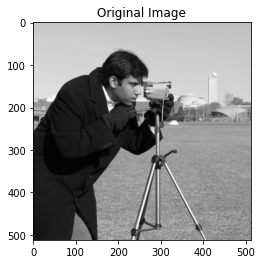

In [4]:
img = data.camera()
plt.imshow(img, cmap='gray')
plt.title('Original Image')
img.shape

strides (1536, 3, 512, 1)


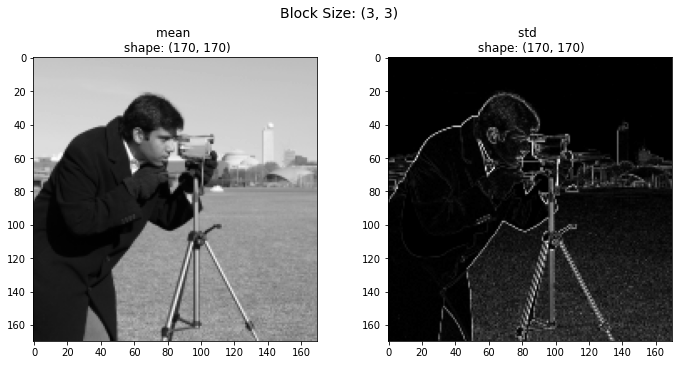

strides (4608, 9, 512, 1)


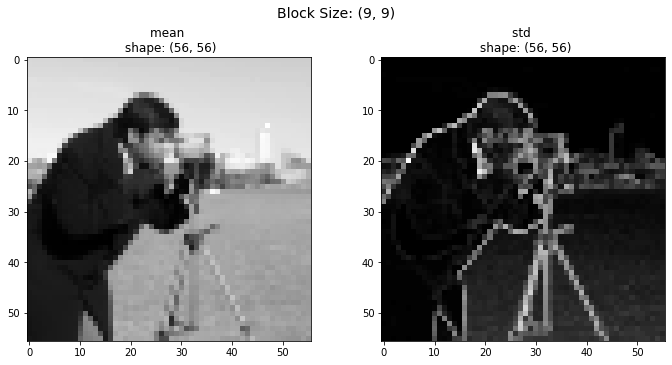

strides (7680, 15, 512, 1)


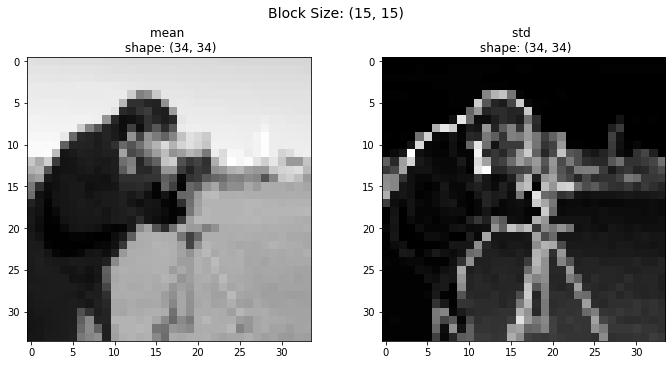

In [5]:
block_sizes = [(3, 3), (9, 9), (15, 15)]


for block_size in block_sizes:

    mean, std = blockwise_mean_std(img, block_size)
    
    fig, (ax1, ax2) =  plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(f'Block Size: {block_size}', fontsize=14)
    
    ax1.imshow(mean, cmap='gray')
    ax1.set_title(f'mean \n shape: {mean.shape}')
    
    ax2.imshow(std, cmap='gray')
    ax2.set_title(f'std \n shape: {mean.shape}')
    fig.tight_layout()
    plt.show()